In [1]:
import re
import STAVAG
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Data loading

The data can be download from  https://ngdc.cncb.ac.cn/STAPR/.

In [2]:
adata = sc.read_h5ad(r'E:\Fast_SVG\Data\planarian_10x_scRNA\ST_3D\python\Visium_0hpa.h5ad')
adata.obs_names_make_unique()
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=10)
mt_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]
non_mt_mask = ~adata.var_names.isin(mt_genes)
adata = adata[:, non_mt_mask]
print(f"Remaining genes: {adata.n_vars}")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.obsm['spatial'] = np.array(adata.obs[['X_3D', 'Y_3D', 'Z_3D']])
adata.obsm['spatial_2D'] = np.array(adata.obs[['X_3D', 'Y_3D']])

Remaining genes: 19594


C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Visualize the planarian data

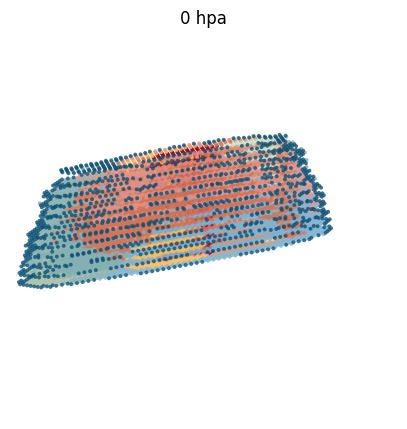

In [5]:
color_map3 =  {'Anterior body': '#84b0b1', 'Body wall-1': '#80b1d3', 'Body wall-2': '#e19388', 'CNS': '#a7c0a9', 
  'Epidermis': '#0e5173', 'Genital chamber': '#cc9a81', 'Gut': '#d57358',
  'Pharynx': '#920e26', 'Protonephridia': '#c9dec3', 'Secertory': '#f6bd60'}
fig = plt.figure(figsize=[5,6])
ax = fig.add_subplot(111, projection='3d') 
ax.set_box_aspect(aspect = (2.2,1,1))

ax.set_xlim([0, 5500])
ax.set_ylim([0, 6000])
ax.set_zlim([0, 500])
plt.axis('off')

ax.set_title("0 hpa")


for it, label_it in enumerate(np.unique(adata.obs['STAGATE'])):
    ad = adata[adata.obs.loc[adata.obs['STAGATE']==label_it,].index,]
    ax.scatter(ad.obs['X_3D'], ad.obs['Y_3D'], ad.obs['Z_3D']*35, alpha=0.8, marker='o',label=label_it, s=8, linewidths=0, c=color_map3[label_it])
    
# Plot edges
#ax.scatter(Edges_3D['Aligned_X'], Edges_3D['Aligned_Y'], Edges_3D['Section_id']*30, c='grey', marker='.', s=1, alpha=0.1)

#plt.legend(bbox_to_anchor =[1, 1])

# View setting
ax.view_init(elev=30, azim=70)
plt.show()

## Detect DVGs

In [3]:
#The columns of coords must be at least 2
#The first column denotes the coordinates on x-axis, the second denotes the coordinates on y-axis
#while the third denotes the coordinates on z-axis
coords = adata.obsm['spatial']
# calculate DVGs along x and y axis
coord_dict = STAVAG.DVG_detection(adata, coords)
DVG_along_x_axis = list(coord_dict['x']['Feature'])
DVG_along_z_axis = list(coord_dict['z']['Feature'])

# Visualize top-10 DVGs along DV axis (z axis)

SMED30013776


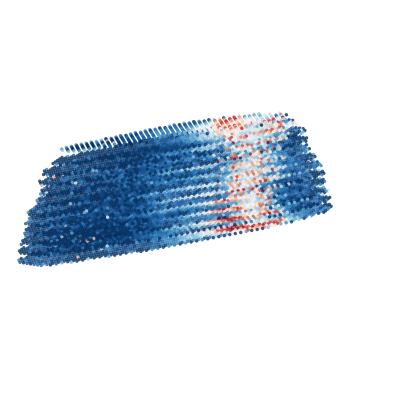

SMED30019357


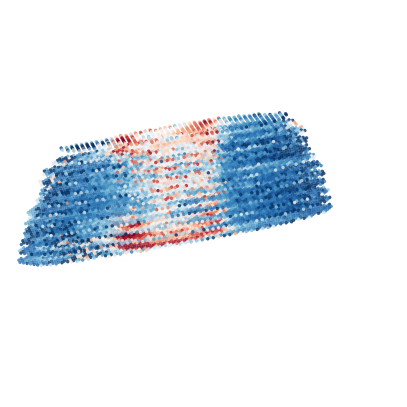

SMED30023762


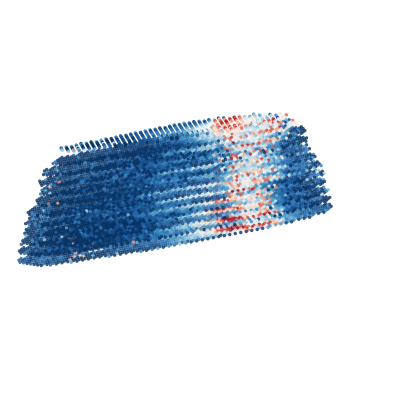

SMED30029969


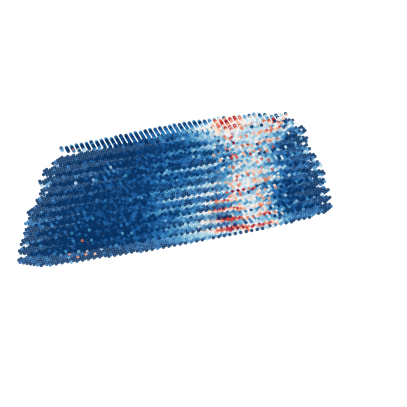

SMED30028226


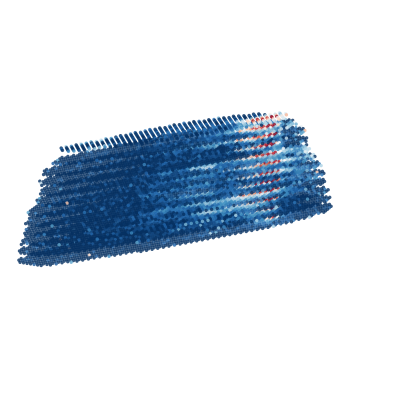

SMED30032991


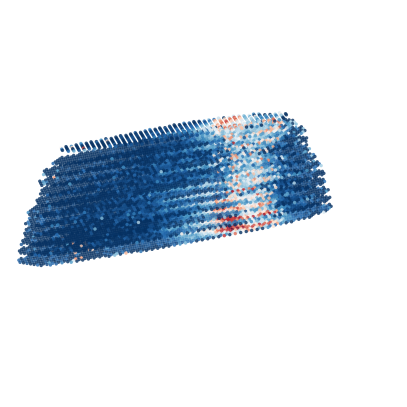

SMED30011206


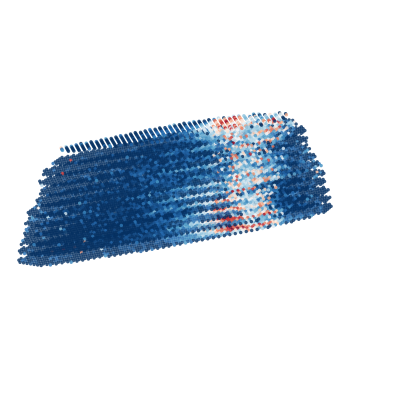

SMED30009662


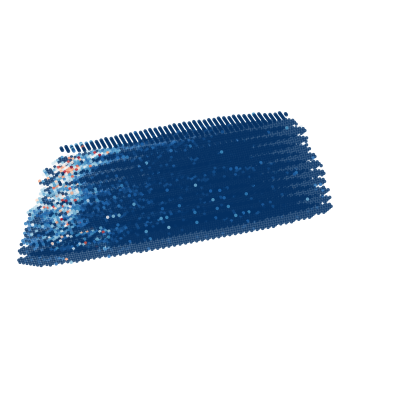

SMED30022285


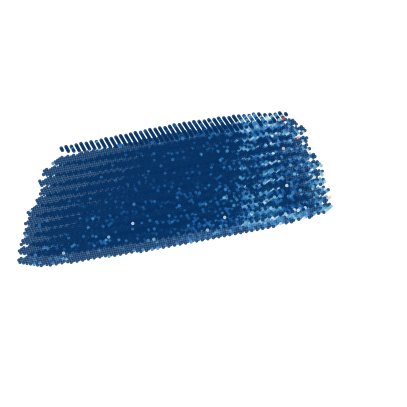

SMED30004645


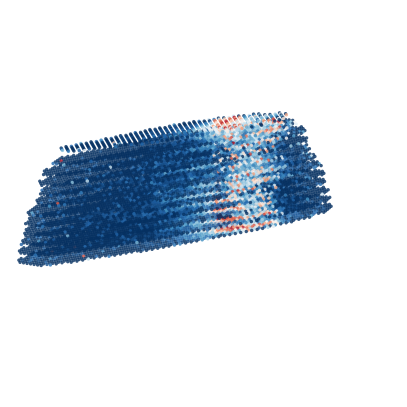

In [25]:
########## Canvas settings ###########
# top_95_percentile = np.percentile(imp_z_rand, 95)
# imp_z_pvalue = imp_z_raw[imp_z_raw['Importance'] > top_95_percentile] 

for ele in DVG_along_x_axis[0:10]:
    fig = plt.figure(figsize=[5, 6])
    ax = fig.add_subplot(111, projection='3d') 
    ax.set_box_aspect(aspect=(2.2, 1, 1))  # Set 3D box aspect ratio
    print(ele)
    
    ax.set_xlim([0, 5500])
    ax.set_ylim([0, 6000])
    ax.set_zlim([0, 500])
    plt.axis('off')  # Turn off axis lines and labels
    
    # ax.set_title("Gene Expression in 3D")
    
    # Specify the gene to visualize
    gene_name = ele  # Replace with the gene of interest
    
    # Extract gene expression values
    gene_expression = adata[:, gene_name].X.toarray().flatten()  # Ensure values are in a 1D array
    
    # Normalize gene expression values for color or size mapping
    norm_expression = (gene_expression - gene_expression.min()) / (gene_expression.max() - gene_expression.min())
    
    coords = adata.obsm['spatial']
    
    # Plot 3D scatter plot
    scatter = ax.scatter(
        adata.obs['X_3D'], 
        adata.obs['Y_3D'], 
        adata.obs['Z_3D'] * 35,  # Scale Z-axis if needed
        c=norm_expression,       # Color based on gene expression
        cmap='RdBu_r',           # Change to other colormaps like "plasma" or "coolwarm"
        alpha=0.8, 
        marker='o', 
        s=6, 
        linewidths=0
    )
    
    # Add colorbar (optional)
    # cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    # cbar.set_label(f"{gene_name} Expression")
    
    # Set 3D view angle
    ax.view_init(elev=30, azim=70)
    
    plt.show()


# Visualize top-10 DVGs along AP axis (x axis)

In [20]:
def plot_3D_FISH(adata, Edges_3D, plot_gene, save=None, plot_elev=-90, plot_azim=-90, vmax=None, vmin=None):
    if (plot_gene in adata.obs.columns)==False:
        adata.obs[plot_gene] = adata[:,plot_gene].X.toarray()
    fig = plt.figure(figsize=[5,6])
    #ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection='3d') 
    ax.set_box_aspect(aspect = (2.2,1,1))

    ax.set_xlim([0, 6000])
    ax.set_ylim([0, 3000])
    ax.set_zlim([0, 500])
    plt.axis('off')
    #ax.set_title("Epidermal")


    ax.scatter(adata.obs['X_3D'], adata.obs['Y_3D'], adata.obs['Z_3D'].map(float), alpha=0.5, vmax=vmax, vmin=vmin, c=adata.obs[plot_gene],
               marker='o',s=10, linewidths=0,  cmap='Blues')

    #plt.legend()
    ax.scatter(Edges_3D['Aligned_X'], Edges_3D['Aligned_Y'], Edges_3D['Aligned_Z'], c='grey', marker='.', s=0.1, alpha=0.1)
    
    
    ax.view_init(elev=plot_elev, azim=plot_azim)

    if (save is None)==False:
        plt.savefig(save, dpi=300, bbox_inches='tight')

SMED30013776


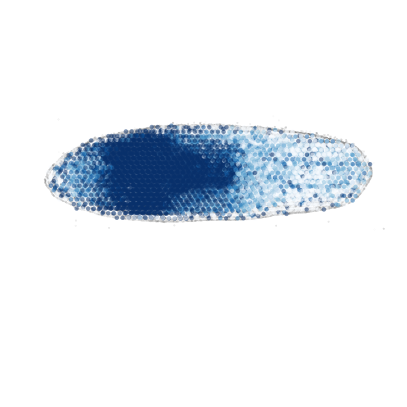

SMED30019357


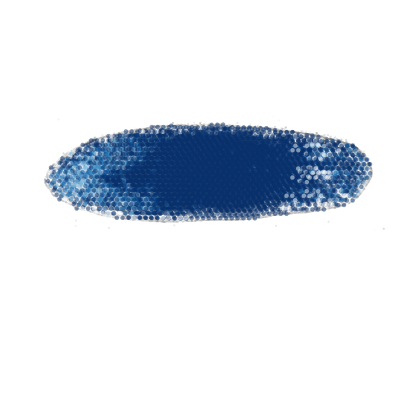

SMED30023762


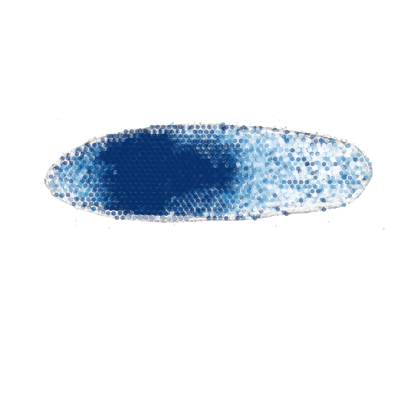

SMED30029969


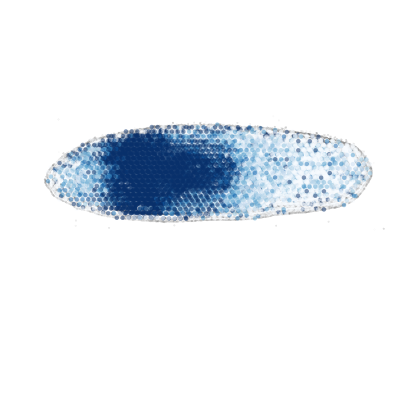

SMED30028226


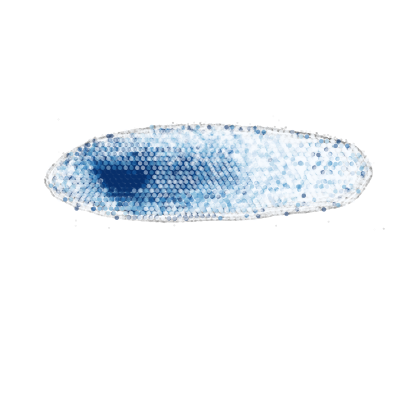

SMED30032991


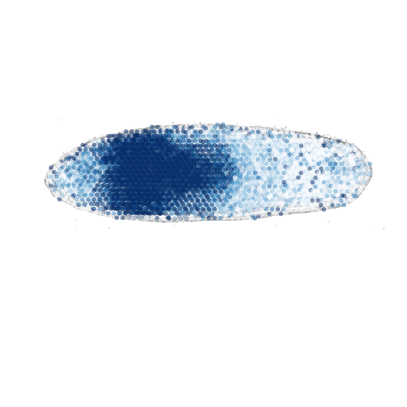

SMED30011206


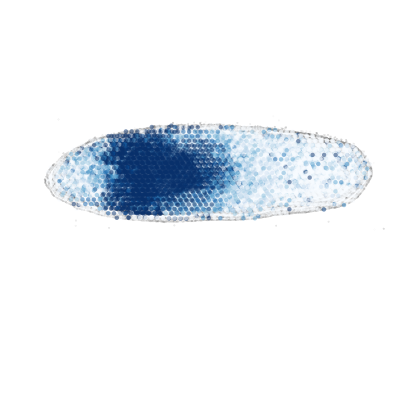

SMED30009662


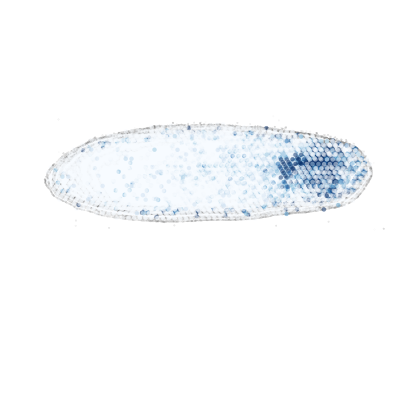

SMED30022285


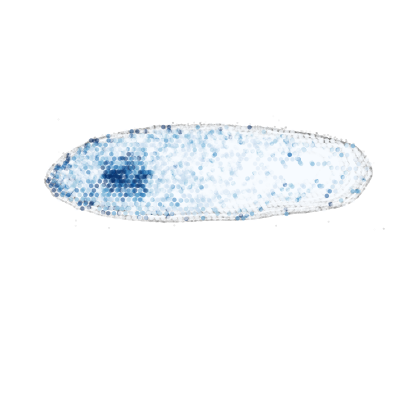

SMED30004645


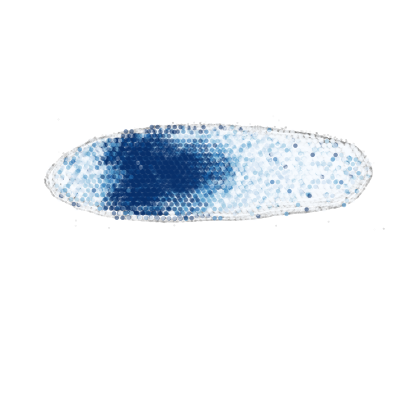

In [27]:
Edges_3D = adata.uns['Edges_3D']
for it in range(10):
    plot_gene = DVG_along_x_axis[it]
    print(plot_gene)
    plot_3D_FISH(adata, Edges_3D, plot_gene, save=None, vmax=1)
    plt.show()